In [1]:
''' mainly used to make sure that C nmr works better than HSQC'''
import umap
import torch
torch.set_printoptions(precision=10)

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
from datasets.hsqc_folder_dataset import FolderDataModule
import yaml
from pytorch_lightning.loggers import TensorBoardLogger
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets import dataset_utils
from datasets.dataset_utils import specific_radius_mfp_loader

            


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np 
import pickle 
import time


In [3]:
# load model 

model_path = Path("/root/MorganFP_prediction/reproduce_previous_works/weird_H_and_tautomer_cleaned/flexible_models_best_FP/r0_r2_FP_trial_2/")

hyperpaerameters_path = model_path / "hparams.yaml"

# checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


with open(hyperpaerameters_path, 'r') as file:
    hparams = yaml.safe_load(file)
    
FP_building_type = hparams['FP_building_type'].split("_")[-1]
only_2d = not hparams['use_oneD_NMR_no_solvent']
print(FP_building_type)
print(int(hparams['FP_choice'].split("_")[-1][1:]))
specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
hparams['use_peak_values'] = False




Normal
2


In [4]:
checkpoint_path = model_path / "checkpoints/epoch=42-all_inputs.ckpt"

model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [5]:
datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
datamodule.setup("predict")

loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
    datamodule.predict_dataloader()

# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [6]:
all_testset_tensors = []
for idx, batch in enumerate(loader_all_inputs):
       
    inputs, (smiles_chemical_name) = batch
    # print(inputs, smiles_chemical_name)
    
    batch[0] = batch[0].to("cuda")
    representation = model.predict_step(batch, idx, dataloader_idx=0, return_representations=True)
    all_testset_tensors.append(representation)

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0

In [7]:
import torch.nn.functional as F
import os
hsqc_mode = None

def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor
 
 
def build_input(compound_dir, mode = hsqc_mode):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    inputs = torch.vstack([
                    get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end"),
                    get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end"), 
                    get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end"),
                    ])   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])



In [8]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode)
inputs = inputs.unsqueeze(0).to("cuda")
rep_kavara = model(inputs, return_representations=True)




Kavaratamide A


cuda:0 cuda:0


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

umap_reducer = umap.UMAP(n_components=2)
X_umap = umap_reducer.fit_transform(all_testset_tensors)

single_umap = umap_reducer.fit_transform([rep_kavara])

plt.figure(figsize=(8, 6))
plt.scatter(x=X_umap[:, 0], y=X_umap[:, 1], c='r', s=10)
plt.scatter(x=X_umap[:, 0], y=X_umap[:, 1], c='g', s=10)


plt.title('UMAP of Iris Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [6]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))
folder_base = Path("/workspace/SMILES_dataset")



all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/smart4.5/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [7]:
# len(all_FP_indices_in_folder), len(all_added_smiles), len(all_FP_indices_to_be_added)

In [8]:
# visualize the all input one 
import os 

chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# chemical_names_lookup[2288]

all_file_indices = [int(i.split(".")[0]) for i in loader_only_hsqc.dataset.files]
all_chemicals = [chemical_names_lookup[file_idx] for file_idx in all_file_indices]
# for i, chemical in enumerate(all_chemicals):
#     print(i, chemical)

In [9]:
which_compound = 5
filename = loader_all_inputs.dataset.files[which_compound]

f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
if os.path.exists(f_path):
    c_tensor, h_tensor = torch.load(f_path)
    
hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# print(f_path)
chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
print(filename)

Chemspider_Pyristriatin A
COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C
10022.pt


In [10]:
(index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

('COC1OC2c3c(cnc(C(=O)CO)c31)CC(O)C1C3=C(C(C)C)CCC3(C)CCC21C',
 'Chemspider_Pyristriatin A')

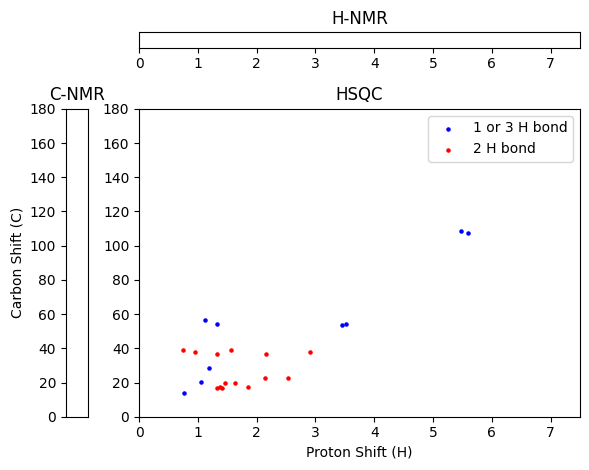

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_NMR(hsqc, c_tensor, h_tensor):
    # print(hsqc, c_tensor, h_tensor)
    # Create a 2x2 grid for subplots
    fig = plt.figure(figsize=(6, 4.8))  # Overall figure size
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 20], width_ratios=[1, 20])

    # Create subplots in different locations and sizes
    ax1 = fig.add_subplot(gs[1, 1])  # Takes up the first row
    if hsqc is not None:
        pos = hsqc[hsqc[:,2]>0]
        neg = hsqc[hsqc[:,2]<0]
        ax1.scatter(pos[:,1], pos[:,0], c="blue", label="1 or 3 H bond", s=5)
        ax1.scatter(neg[:,1], neg[:,0], c="red", label="2 H bond", s=5)
        # print("scatter!!")
        # print(pos, neg)
    ax1.set_title("HSQC")
    ax1.set_xlabel('Proton Shift (H)')  # X-axis label
    ax1.set_xlim([0, 7.5])
    ax1.set_ylim([0, 180])
    ax1.legend()


    ax2 = fig.add_subplot(gs[1, 0])  # Smaller subplot
    if c_tensor is not None:
        ax2.scatter( torch.ones(len(c_tensor)), c_tensor, c="black", s=2)
    ax2.set_ylim([0, 180])
    ax2.set_title("C-NMR")
    ax2.set_ylabel('Carbon Shift (C)')
    ax2.set_xticks([])

    ax3 = fig.add_subplot(gs[0, 1])  # Smaller subplot
    if h_tensor is not None:
        ax3.scatter(h_tensor, torch.ones(len(h_tensor)),c="black", s=2)
    ax3.set_xlim([0, 7.5])
    ax3.set_title("H-NMR")
    ax3.set_yticks([])

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_NMR(hsqc, c_tensor, h_tensor)

In [12]:
import torch.nn.functional as F
import heapq

def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
    results = []
    for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
    # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
        # print(ranker_f)
        num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
        data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
        query_products = (data @ query)
        values, indices = torch.topk(query_products,k=k)
        if len(results) == 0:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
        else:
            for value, idx in zip(values, indices):
                real_idx = idx + 2000*num_ranker_data
                heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret

def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
    query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

    results = []
    query_products = (data @ query)
    values, indices = torch.topk(query_products,k=k)
    
    for value, idx in zip(values, indices):
        results.append((value, idx, data[idx].nonzero()))
                
                        
    results.sort(key=lambda x: x[0],reverse=True)
    ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
    # print(torch.tensor(idx))
    # retrieved_FP = [all_fp[i] for i in idx]
    # print(results[0])
  
    return ret
        

In [13]:
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names.pkl', 'rb'))
# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_only_2d_dataset.pkl', 'rb'))
smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/SMILES_chemical_names_remove_stereoChemistry.pkl', 'rb'))

# smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/test_smiles_and_names.pkl', 'rb'))

In [14]:
# rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_only_2d_dataset/FP.pt'
rankingset_path = '/root/MorganFP_prediction/inference_data/max_radius_2_only_2d_False_together_no_stereoChemistry_dataset/FP.pt'

rankingset_data = torch.load(rankingset_path).to("cuda")

smiles_to_NMR_path = pickle.load(open('/root/MorganFP_prediction/inference_data/SMILES_chemical_to_NMR_paths.pkl','rb'))

In [15]:
smiles_to_NMR_path['COC1OC(CO)C(O)C(O)C1O']

('/workspace/SMILES_dataset/test/HSQC/10002.pt',
 '/workspace/SMILES_dataset/test/oneD_NMR/10002.pt')

In [16]:
def unpack_inputs(inputs):
    for i, vals in enumerate(inputs[0]):
        # if vals is [-1, -1, -1]
        if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
            hsqc_start=i+1
        elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
            hsqc_end=i
        elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
            c_nmr_start=i+1
        elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
            c_nmr_end=i
        elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
            h_nmr_start=i+1
        elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
            h_nmr_end=i
            
    hsqc = inputs[0,hsqc_start:hsqc_end]
    c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
    h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
    return hsqc, c_tensor, h_tensor

# unpack_inputs(inputs)

######### compound number: 0##############################################################
cuda:0 cuda:0
Ground Truth NMR


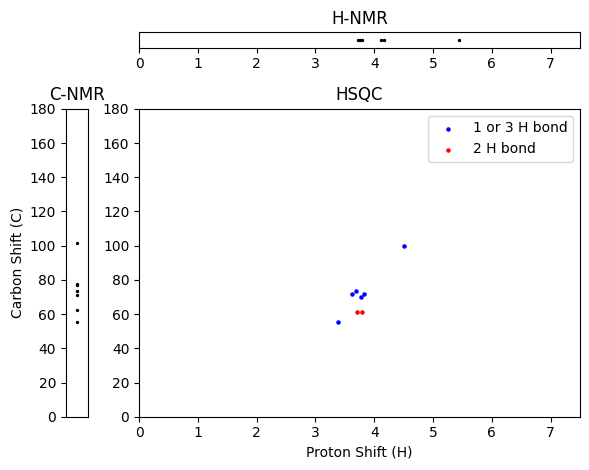

Chemical name METHYL GALACTOSIDE
Ground truth smiles COC1OC(CO)C(O)C(O)C1O
Ground truth NMR path /workspace/SMILES_dataset/test/oneD_NMR/10002.pt


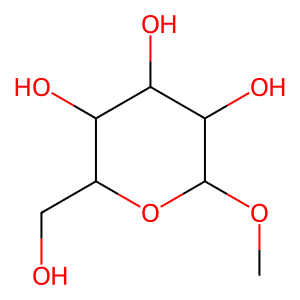

____________________________retival #1, cosine similarity: 0.9551191926002502_____________________________
retrieved path:  /workspace/SMILES_dataset/test/oneD_NMR/10002.pt
SMILES: COC1OC(CO)C(O)C(O)C1O
Name methyl beta-D-glucopyranoside


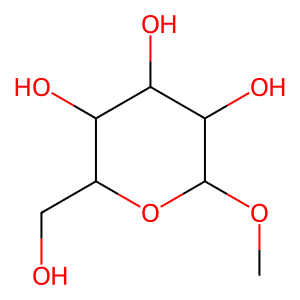

____________________________retival #2, cosine similarity: 0.9526838064193726_____________________________
retrieved path:  /workspace/OneD_Only_Dataset/train/oneD_NMR/218913.pt
SMILES: COC1OC(CO)C(O)C1O
Name (2s,3r,4r,5r)-2-(hydroxymethyl)-5-methoxyoxolane-3,4-diol


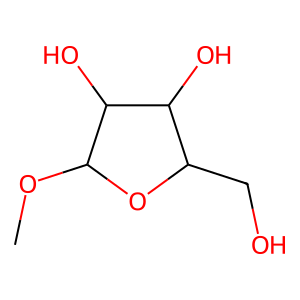

######### compound number: 1##############################################################
cuda:0 cuda:0
Ground Truth NMR


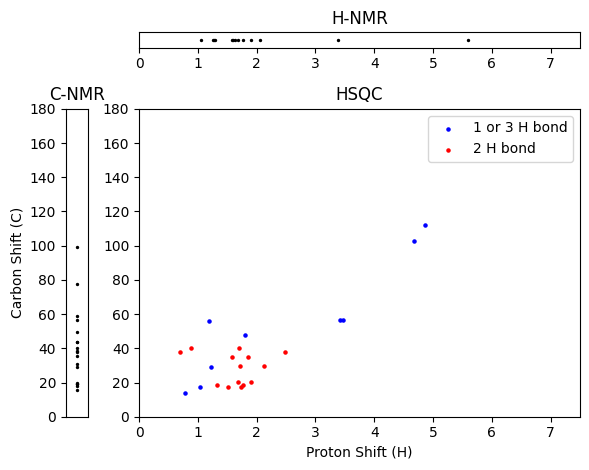

Chemical name dihydroxy-dimethoxyspongian-19-oic acid
Ground truth smiles COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O
Ground truth NMR path /workspace/SMILES_dataset/test/oneD_NMR/10013.pt


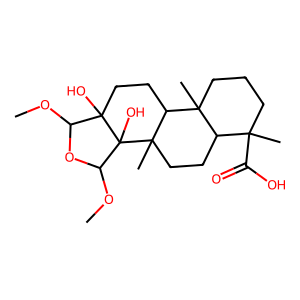

____________________________retival #1, cosine similarity: 0.8206808567047119_____________________________
retrieved path:  /workspace/SMILES_dataset/test/oneD_NMR/10013.pt
SMILES: COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O
Name dihydroxy-dimethoxyspongian-19-oic acid


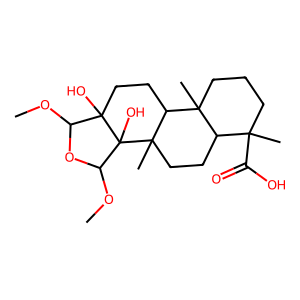

____________________________retival #2, cosine similarity: 0.8070619106292725_____________________________
retrieved path:  /workspace/SMILES_dataset/train/oneD_NMR/80425.pt
SMILES: COC1OC(OC)C2=C1CCC1C2(C)CCC2C(C)(C(=O)O)CCCC21C
Name 15α,16-dimethoxyspongi-13-en-19-oic acid


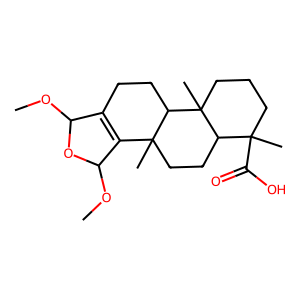

In [30]:
'''for a single model, show top-5'''
# model.to("cuda")
for  which_compound in range(0, 2):  
    
    print(f"######### compound number: {which_compound}##############################################################")
    
    for idx, batch in enumerate(loader_all_inputs):
        if idx < which_compound:
            continue
        inputs, (smiles_chemical_name) = batch
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
        inputs = inputs.to("cuda")
        pred = model(inputs)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=2)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    
    i=0
    for value, (smile, name, _, _), predicted_FP in topk:
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", predicted_FP.squeeze().tolist())
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
        # plot_NMR(hsqc, c_tensor, h_tensor)
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [31]:
smiles_chemical_name

[['COC1OC(OC)C2(O)C3(C)CCC4C(C)(C(=O)O)CCCC4(C)C3CCC12O',
  'dihydroxy-dimethoxyspongian-19-oic acid',
  '/workspace/SMILES_dataset/test/oneD_NMR/10013.pt']]

In [32]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [52]:
# !!!
"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred=torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), predicted_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", predicted_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        hsqc_path, oned_path = smiles_to_NMR_path[smile]
        #check is path file exists
        hsqc, c_tensor, h_tensor = None, None, None
        # print("retrieved path: ",oned_path)
        if os.path.exists(hsqc_path):
            hsqc = torch.load(hsqc_path)
        if os.path.exists(oned_path):
            c_tensor, h_tensor = torch.load(oned_path)
            
        if hsqc is not None:
            if mode == "no_sign":
                hsqc = torch.abs(hsqc)
            elif mode == "flip_sign":
                hsqc[:,2] = -hsqc[:,2]
        plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [53]:
def build_input(compound_dir, mode = hsqc_mode):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    inputs = torch.vstack([
                    get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end"),
                    get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end"), 
                    get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end"),
                    ])   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])




Kavaratamide A




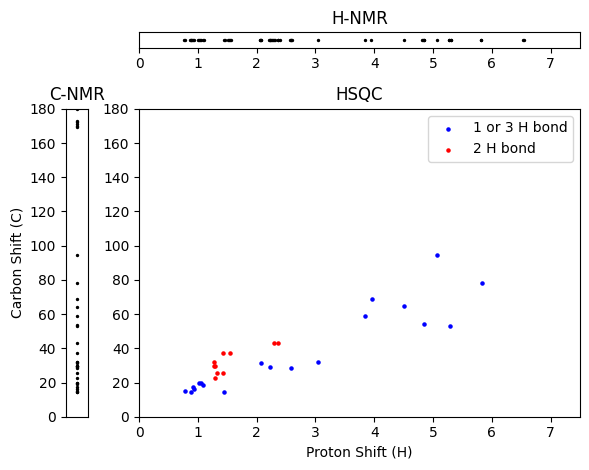

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, cosine similarity: 0.6955295205116272_____________________________
SMILES: CC(O)CCCCC(C)C1CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N(C)C(C(C)C)C(=O)O1
Name Colletopeptide C


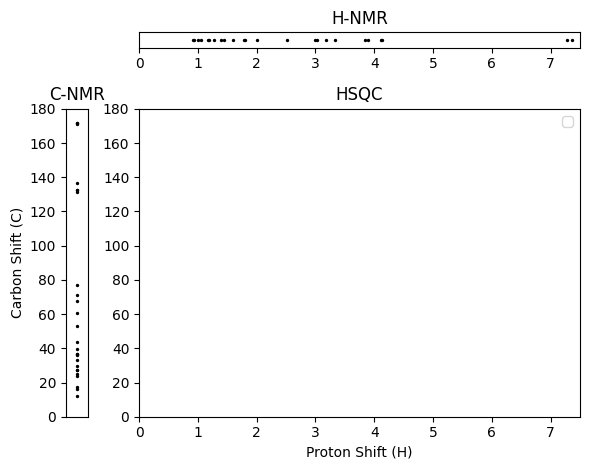

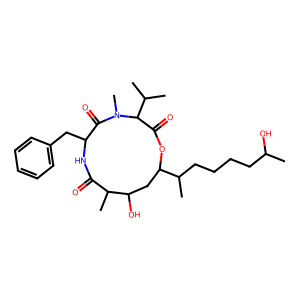

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #2, cosine similarity: 0.685763418674469_____________________________
SMILES: CCC(C)C1C(=O)OC(CCCCCC(C)O)CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N1C
Name Colletopeptide D


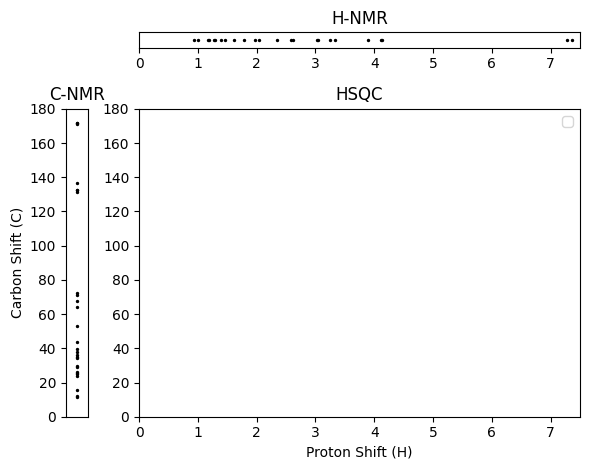

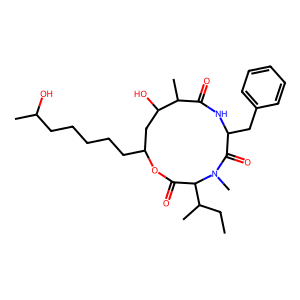

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #3, cosine similarity: 0.6800233125686646_____________________________
SMILES: CCC(C)C1C(=O)OC(C(C)CCCCC(C)O)CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N1C
Name Colletopeptide A


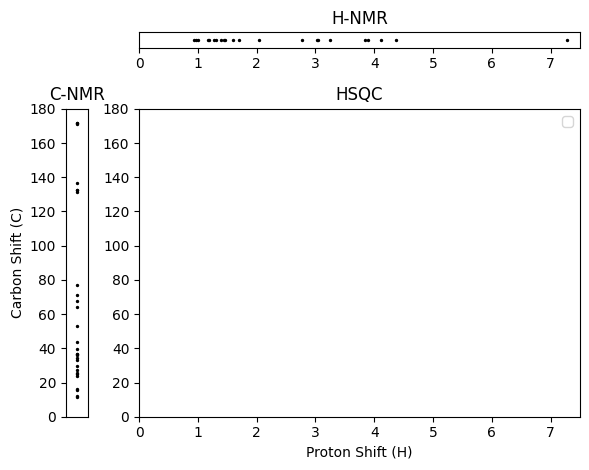

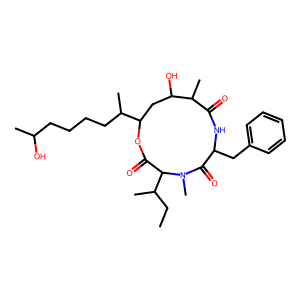

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #4, cosine similarity: 0.6663823127746582_____________________________
SMILES: CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CCCC)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name (-)-Micropeptin E


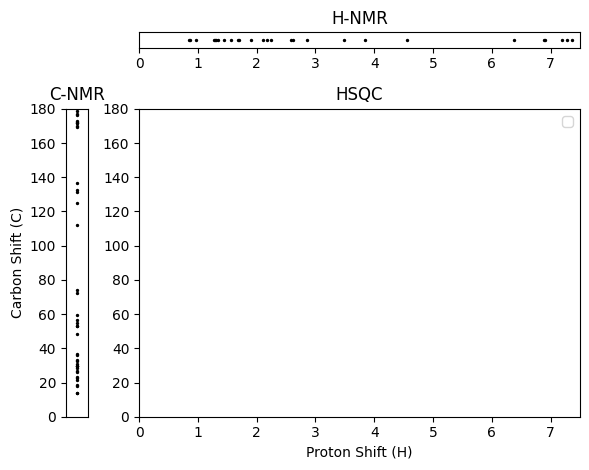

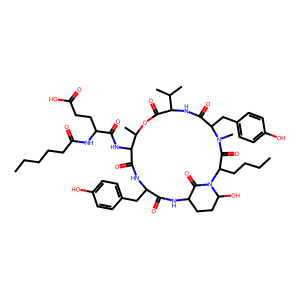

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #5, cosine similarity: 0.6659449934959412_____________________________
SMILES: CCCCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CCCC)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name (-)-Micropeptin F


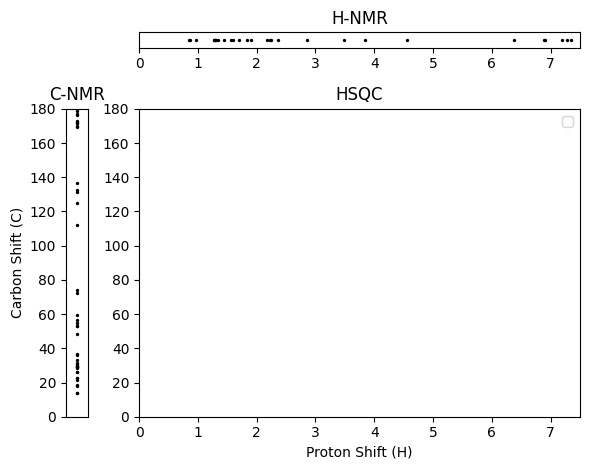

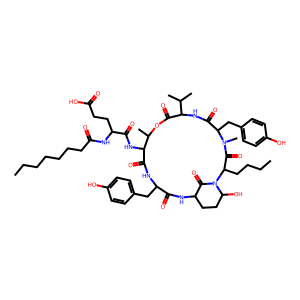

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #6, cosine similarity: 0.6602314710617065_____________________________
SMILES: CC(C)CC1C(=O)OC(C(C)CCCCC(C)O)CC(O)C(C)C(=O)NC(Cc2ccccc2)C(=O)N1C
Name Colletopeptide B


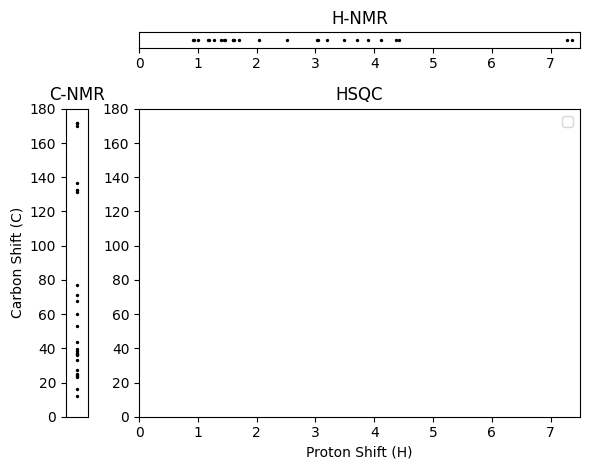

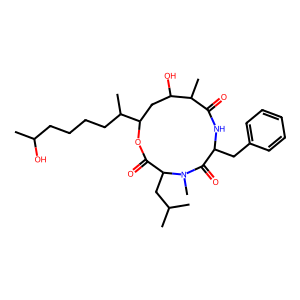

____________________________retival #7, cosine similarity: 0.6597244739532471_____________________________
SMILES: CCCC(=O)NC1C(=O)NC(CC(C)C)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC1C
Name tasipeptin B


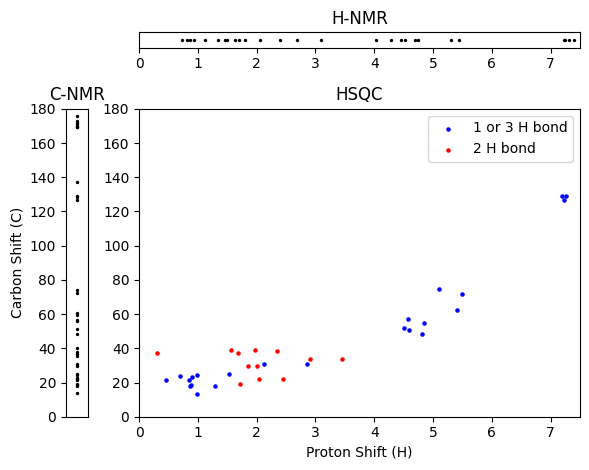

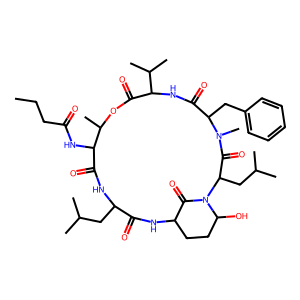

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #8, cosine similarity: 0.6567486524581909_____________________________
SMILES: CCCCCCC=CCCCC(=O)NC1C(=O)NC(CO)C(=O)NC(CO)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Stephensiolide E


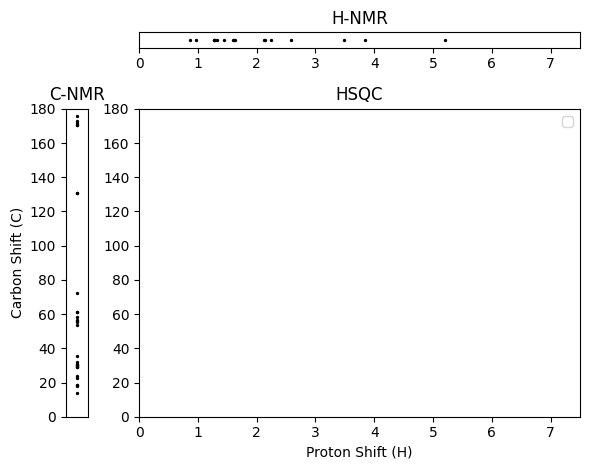

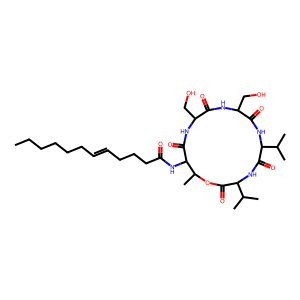

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #9, cosine similarity: 0.6557931900024414_____________________________
SMILES: CCCCCCC1OC(=O)NCC(=O)C(C(C)C)NC(=O)C(CO)NC(=O)C(C(C)C)NC(=O)C(C(C)C)N(C)C(=O)C1C
Name SF-1902-A3


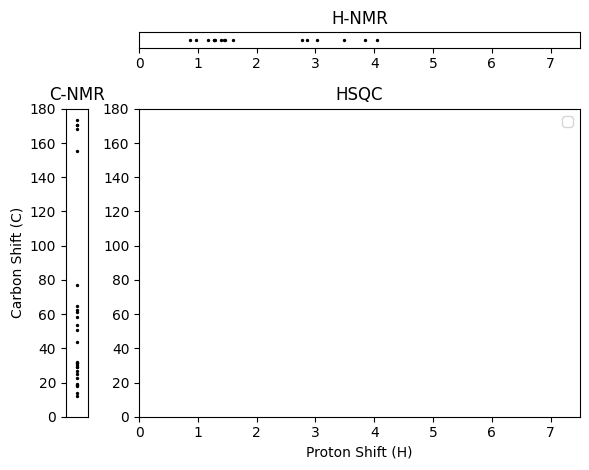

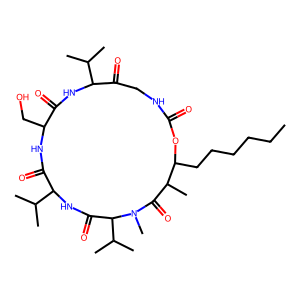

____________________________retival #10, cosine similarity: 0.6549758911132812_____________________________
SMILES: CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(Cc2ccccc2)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name micropeptin C


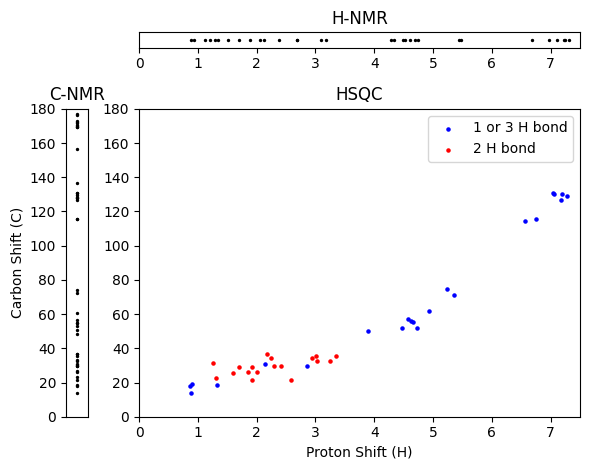

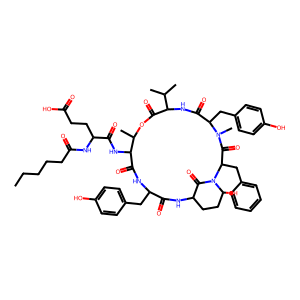

____________________________retival #11, cosine similarity: 0.6545753479003906_____________________________
SMILES: CCCCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(Cc2ccccc2)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name Micropeptin D


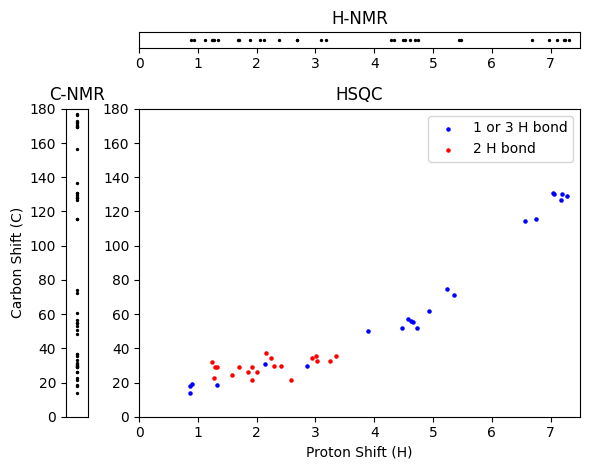

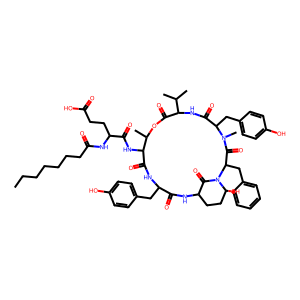

____________________________retival #12, cosine similarity: 0.653398871421814_____________________________
SMILES: CCCCCC(=O)NC(CC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(C(C)CC)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name micropeptin SD979


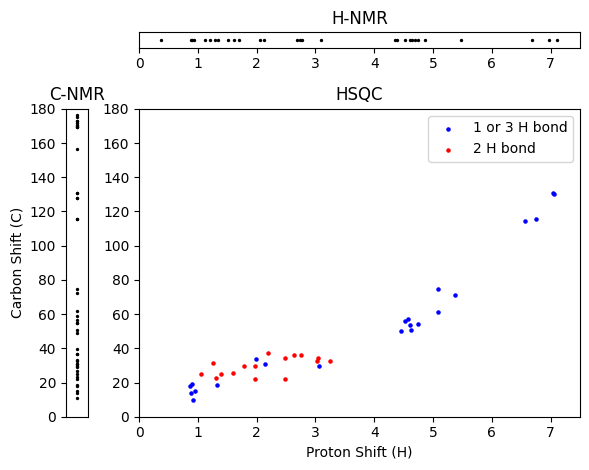

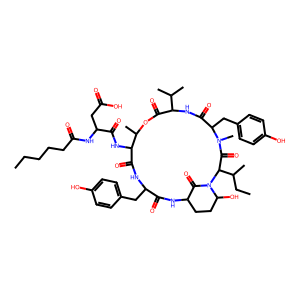

____________________________retival #13, cosine similarity: 0.6532405614852905_____________________________
SMILES: CCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name micropeptin E


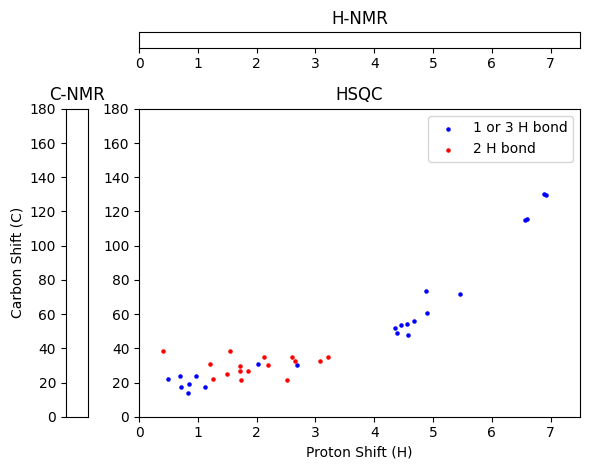

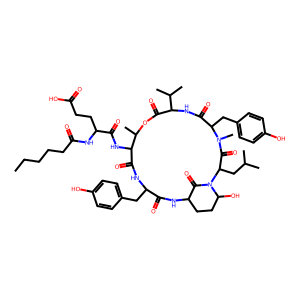

____________________________retival #14, cosine similarity: 0.652856171131134_____________________________
SMILES: CCCCCCCC(=O)NC(CCC(=O)O)C(=O)NC1C(=O)NC(Cc2ccc(O)cc2)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)NC(C(C)C)C(=O)OC1C
Name Micropeptin F


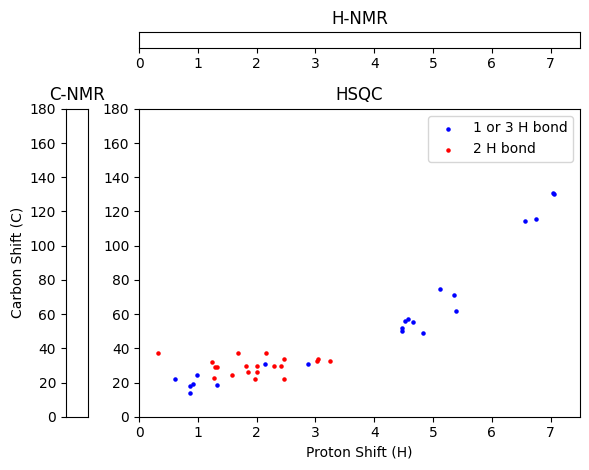

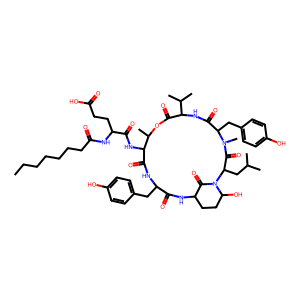

____________________________retival #15, cosine similarity: 0.6520746946334839_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Tasipeptin A


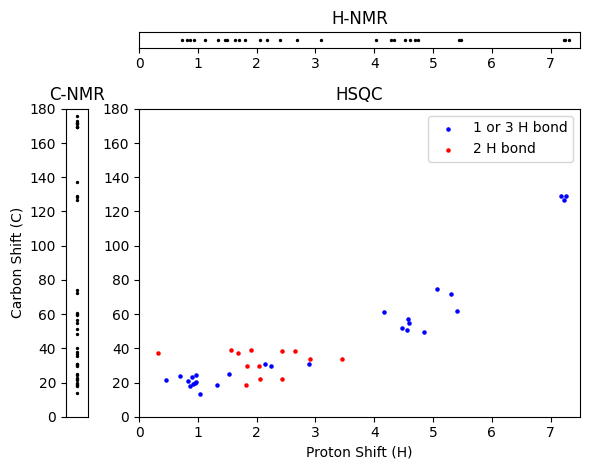

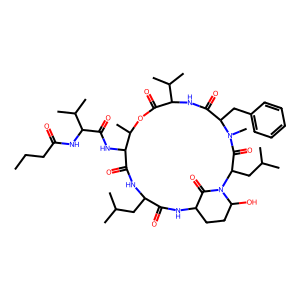

____________________________retival #16, cosine similarity: 0.6517487168312073_____________________________
SMILES: CCCCCCC=CCC(=O)NC(Cc1ccc(O)cc1)C(=O)NC(C(=O)NC1C=CC(=O)NC(C(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)OC1)C(C)C
Name Thalassospiramide C


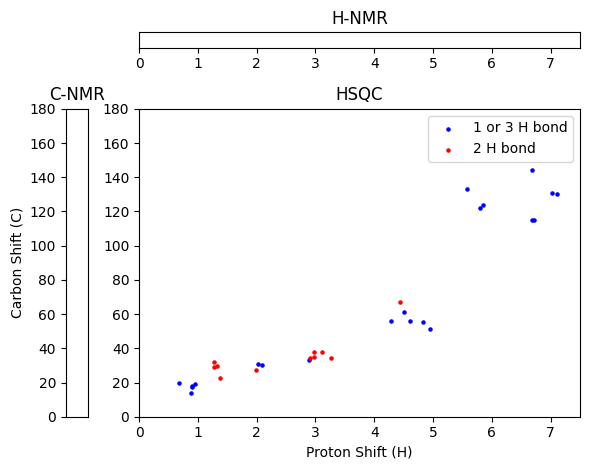

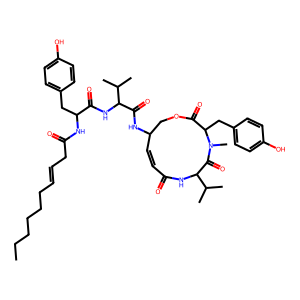

____________________________retival #17, cosine similarity: 0.649403989315033_____________________________
SMILES: CCCCCCCC1OC(=O)CC(O)C(Cc2ccccc2)N(C)C(=O)C(C(C)C)OC(=O)C1C
Name Hapalosin


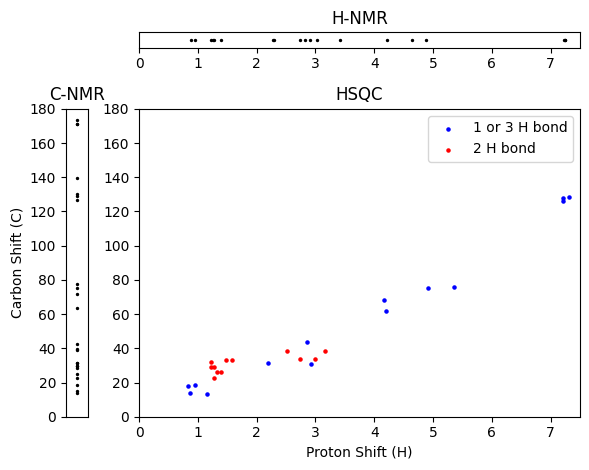

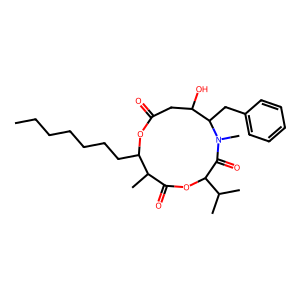

____________________________retival #18, cosine similarity: 0.6480875015258789_____________________________
SMILES: CCCC1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(OC)cc2)N(C)C(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin B


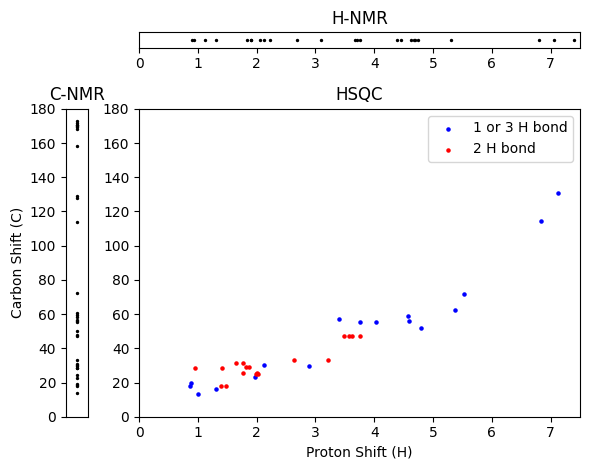

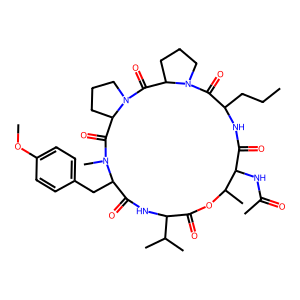

____________________________retival #19, cosine similarity: 0.6479295492172241_____________________________
SMILES: CCCCCC1OC(=O)C(C(C)C)N(C)C(=O)C2CCCN2C(=O)C(C(C)C)OC(=O)C(C(C)C)N(C)C(=O)C(C(C)C)NC(=O)C1C
Name veraguamide J


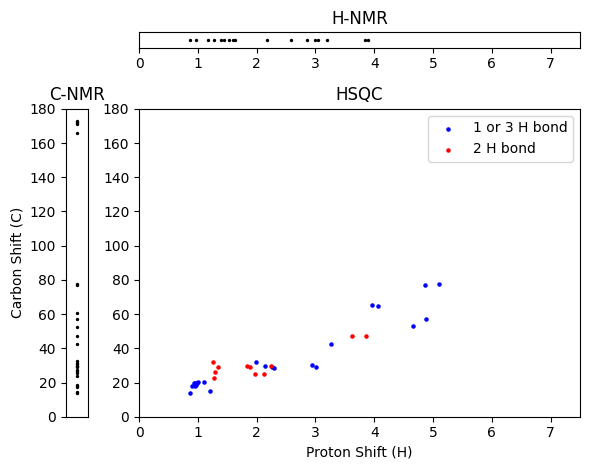

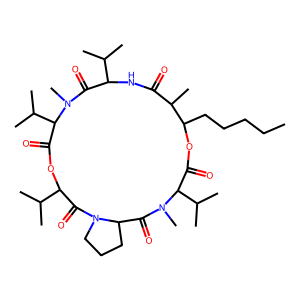

____________________________retival #20, cosine similarity: 0.6478281021118164_____________________________
SMILES: CCCCCCC=CCC(=O)NC(CO)C(=O)NC(C(=O)NC1C=CC(=O)NC(C(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)OC1)C(C)C
Name thalassospiramide C2


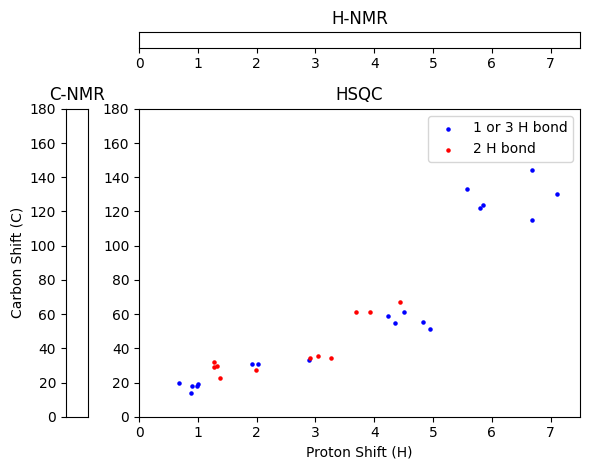

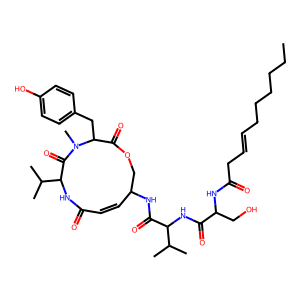

In [54]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode)
show_topK(inputs, k=20, mode=mode)
# show_topK(inputs, k=1)




new_compound_A




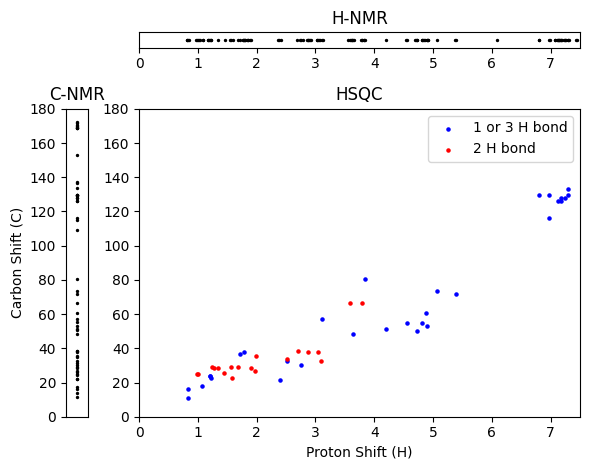

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, cosine similarity: 0.7151656150817871_____________________________
SMILES: CCC(C)C1C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC(C)C(NC(=O)C(CC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(=O)NC(CC(C)C)C(=O)NC2CCC(OC)N1C2=O
Name Micropeptin KB992


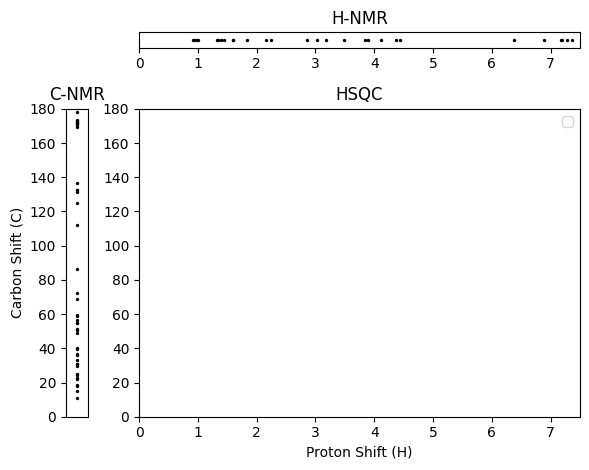

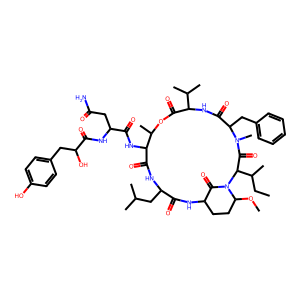

____________________________retival #2, cosine similarity: 0.7142311930656433_____________________________
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name micropeptin MZ859


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


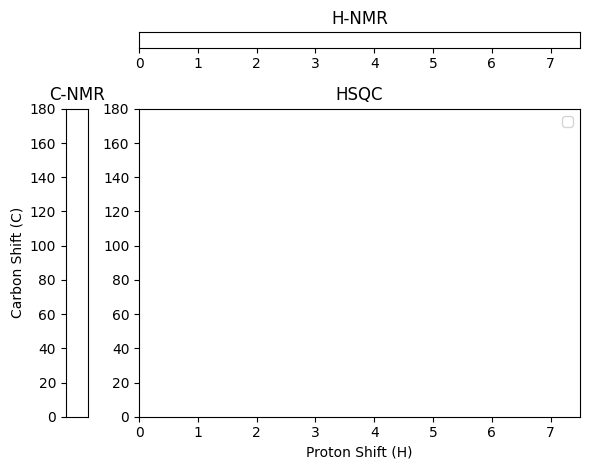

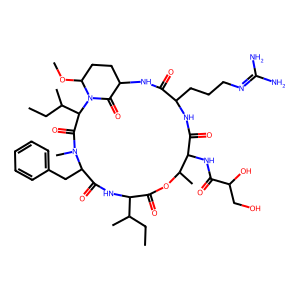

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #3, cosine similarity: 0.7128764390945435_____________________________
SMILES: CCCC(=O)NC(Cc1ccc(O)cc1)C(=O)NC(CCC(=O)NC1C(=O)NC(CCCN=C(N)N)C(=O)NC2CCC(O)N(C2=O)C(C(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)CC)C(=O)OC1C)C(=O)OC
Name Micropeptin 1120


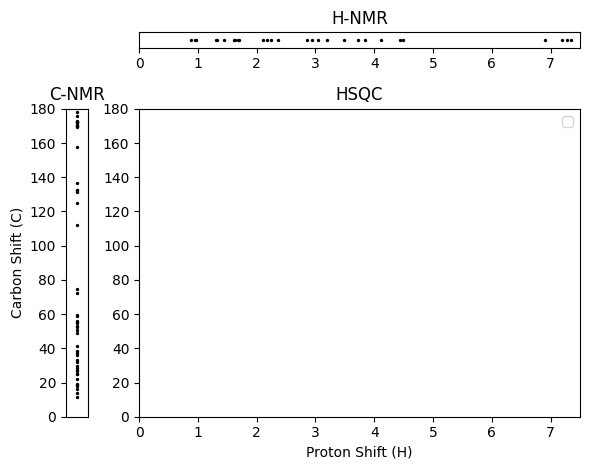

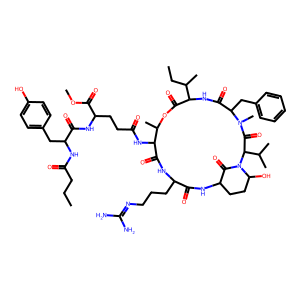

In [55]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir)
show_topK(inputs, k=3)




new_compound_B1




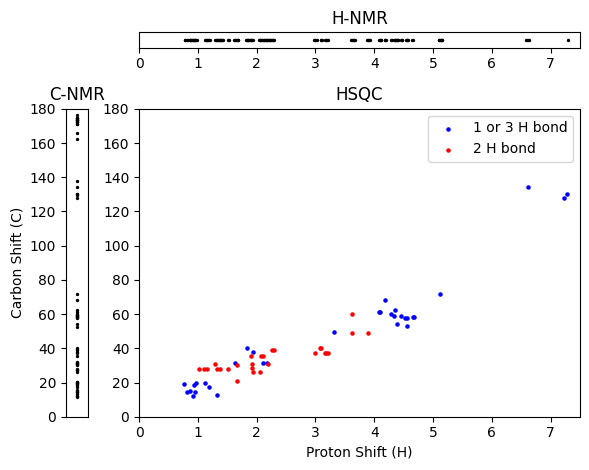

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, cosine similarity: 0.7182429432868958_____________________________
SMILES: CC=C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(CO)NC(=O)C1CCCN1C(=O)C(=CC)NC(=O)CC(O)CCCCC)C(C)C)C(C)C)C(C)C)C(C)C)C(=O)NC1C(=O)NC(C(C)C)C(=O)NC(CCO)C(=O)NC(CCN)C(=O)NC(CCCCN)C(=O)OC1C
Name Tolaasin B


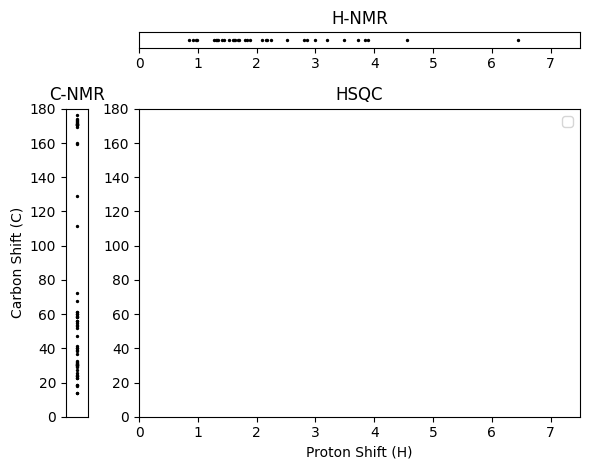

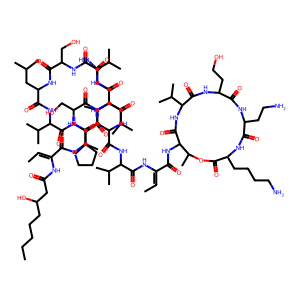

____________________________retival #2, cosine similarity: 0.7099109888076782_____________________________
SMILES: CCCCCCCCCCCCCCC(=O)NC(CCCN)C(=O)NC(C(=O)NC1C(=O)NC(CCCN)C(=O)NC(CO)C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(CO)C(=O)NC(C(C)CC)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CCCCN)C(=O)NC(C(C)CC)C(=O)OC1C)C(C)C
Name Paenibacterin


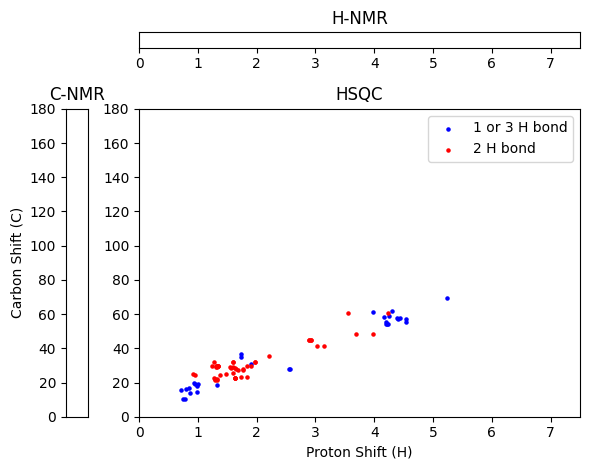

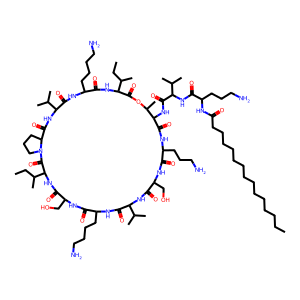

____________________________retival #3, cosine similarity: 0.707639753818512_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


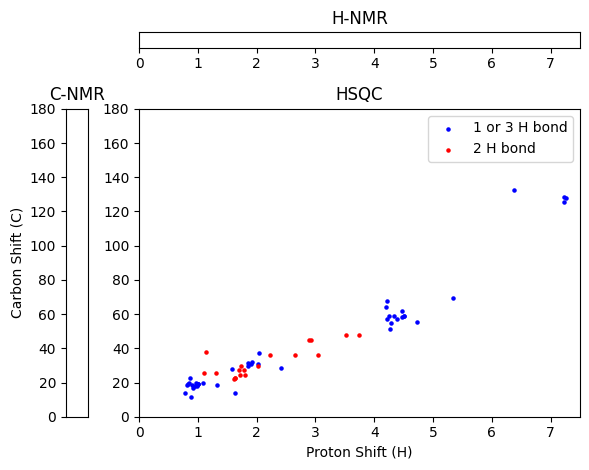

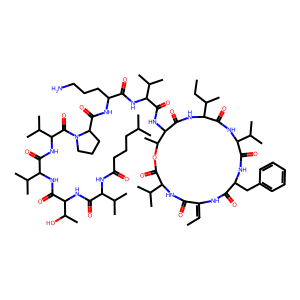

In [56]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir)
show_topK(inputs, k=3)




new_compound_B2




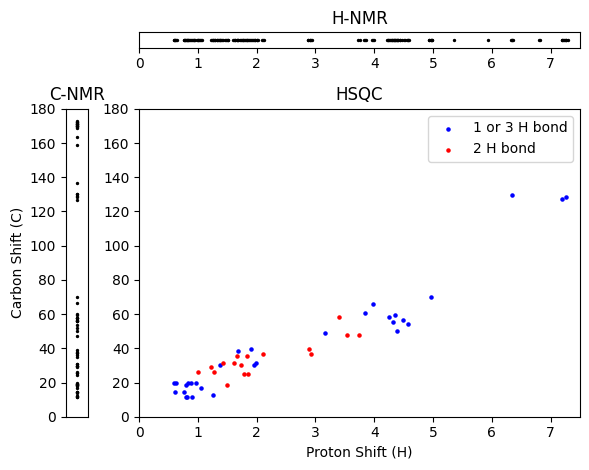

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


_________________________________________________________
cuda:0 cuda:0
____________________________retival #1, cosine similarity: 0.7942938804626465_____________________________
SMILES: CCC(C)C1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide N


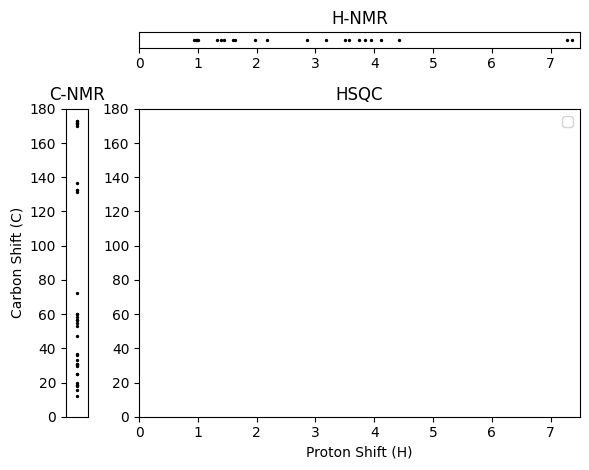

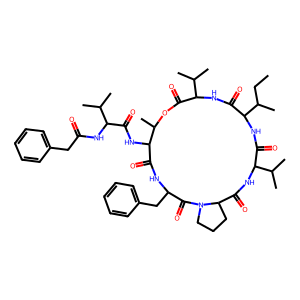

____________________________retival #2, cosine similarity: 0.7902377247810364_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name xentrivalpeptide D


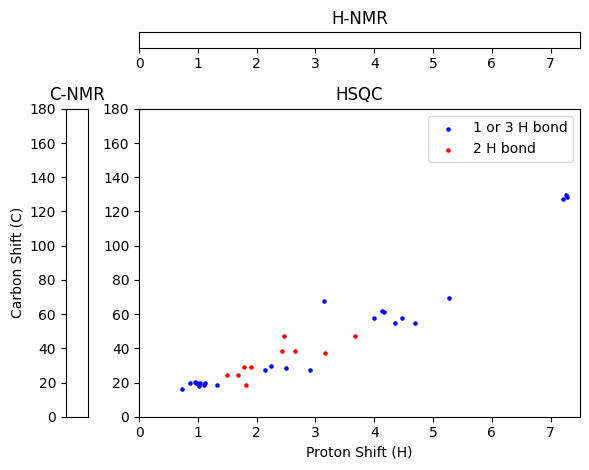

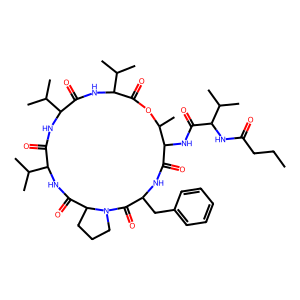

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #3, cosine similarity: 0.7809578776359558_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(CC)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide P


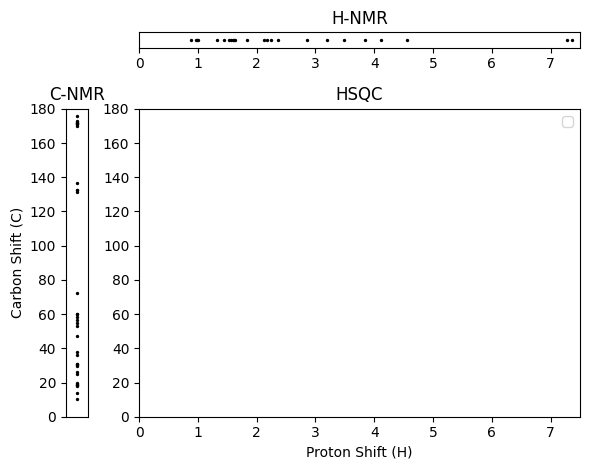

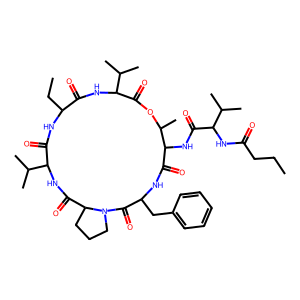

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #4, cosine similarity: 0.7766329050064087_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide E


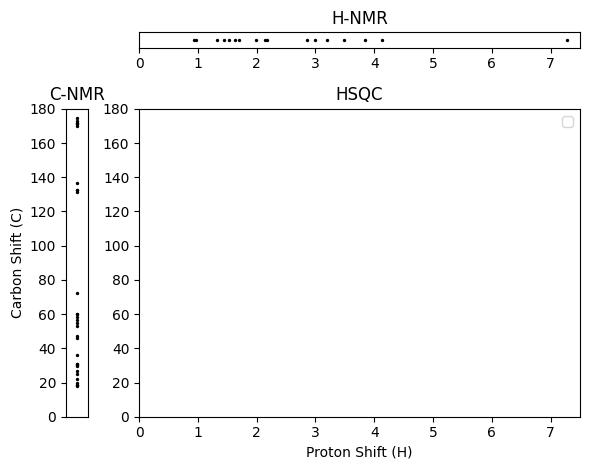

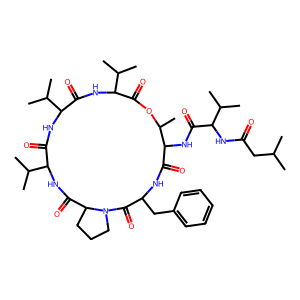

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #5, cosine similarity: 0.7764270305633545_____________________________
SMILES: CCCCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide G


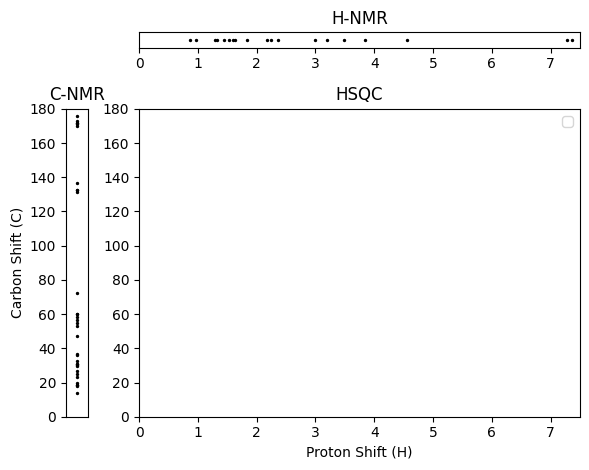

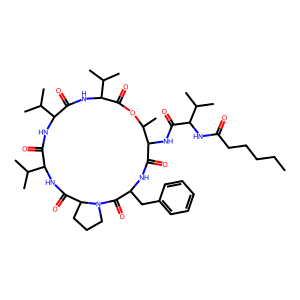

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #6, cosine similarity: 0.7755885124206543_____________________________
SMILES: CCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide C


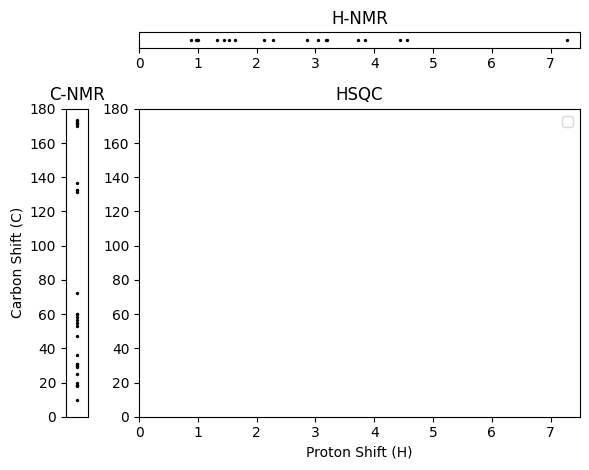

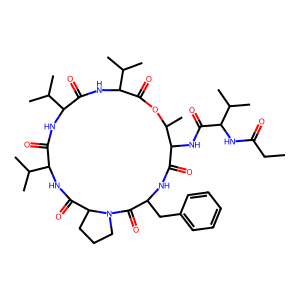

____________________________retival #7, cosine similarity: 0.7708223462104797_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name 1401343-49-4


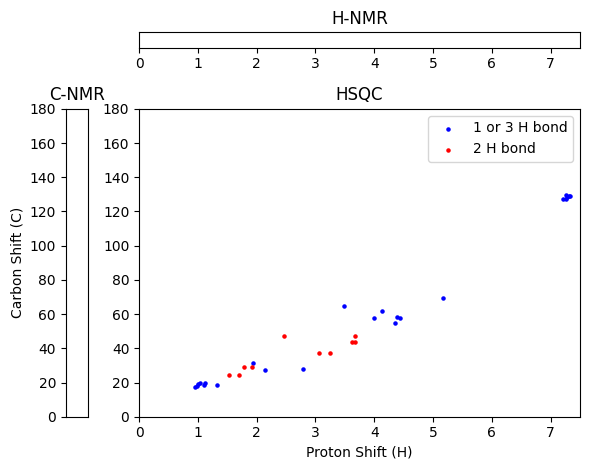

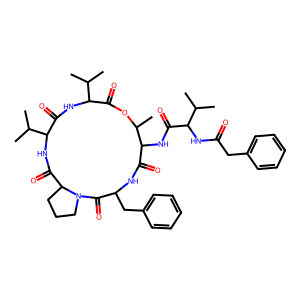

____________________________retival #8, cosine similarity: 0.7708223462104797_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name xentrivalpeptide A


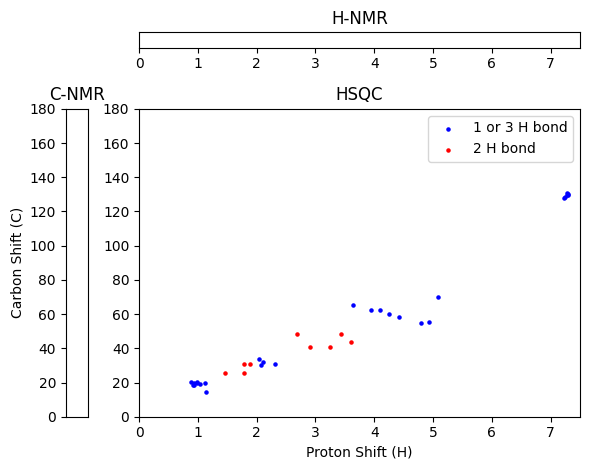

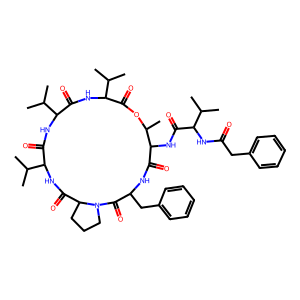

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #9, cosine similarity: 0.768426775932312_____________________________
SMILES: CCC1NC(=O)C(C(C)C)NC(=O)C2CCCN2C(=O)C(Cc2ccccc2)NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name Xentrivalpeptide O


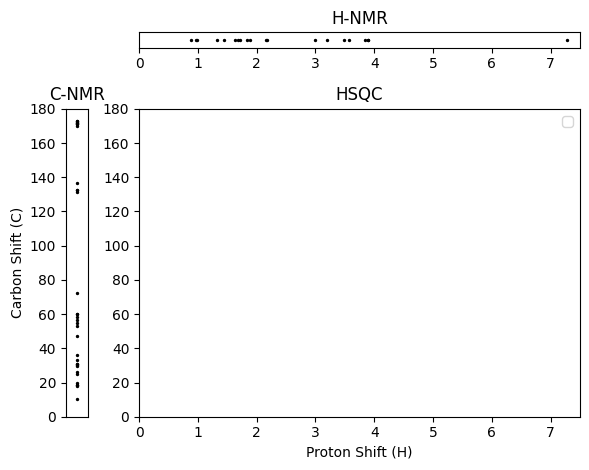

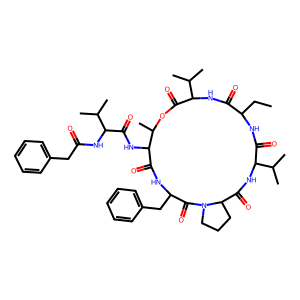

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #10, cosine similarity: 0.7649291753768921_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide F


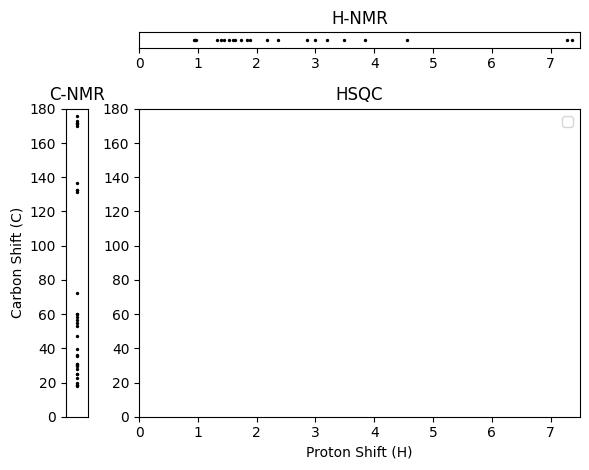

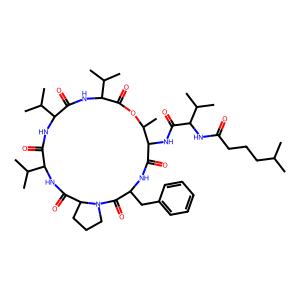

____________________________retival #11, cosine similarity: 0.7648700475692749_____________________________
SMILES: CC(C)CC1NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C2CCCN2C1=O
Name Xentrivalpeptide L


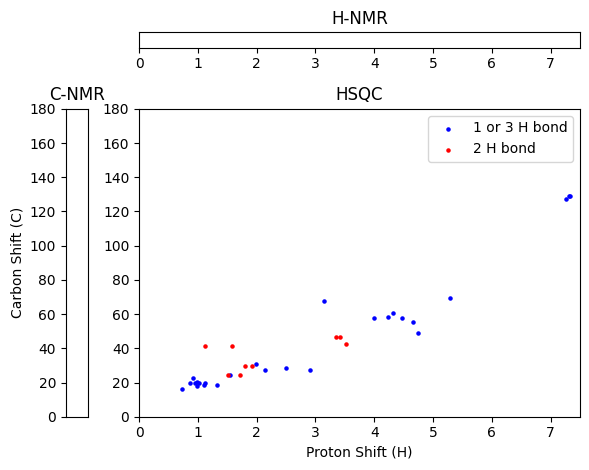

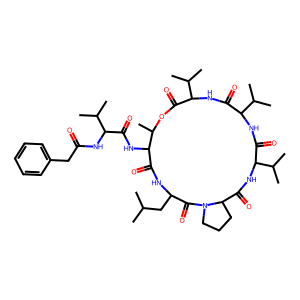

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #12, cosine similarity: 0.7626991271972656_____________________________
SMILES: CCC(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide H


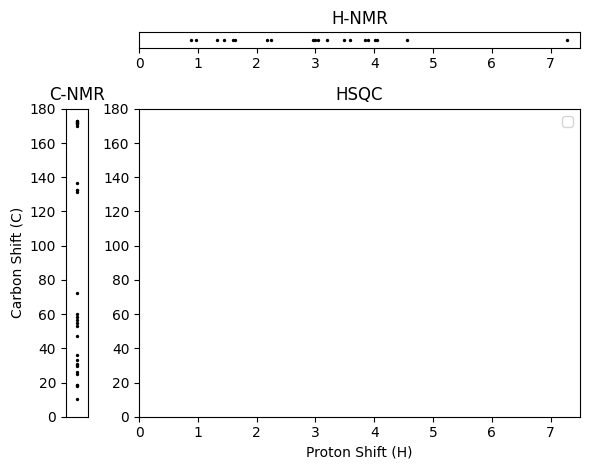

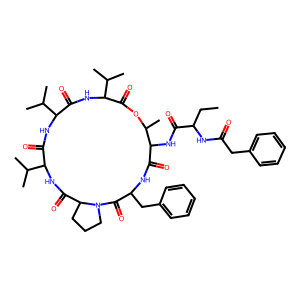

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #13, cosine similarity: 0.7613987922668457_____________________________
SMILES: CCC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name Xentrivalpeptide I


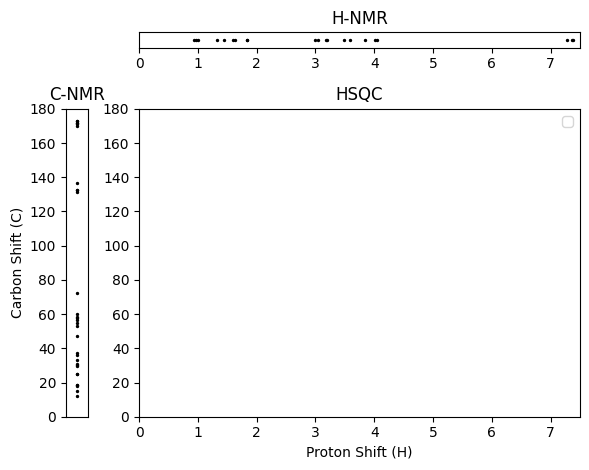

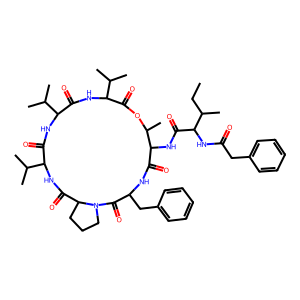

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #14, cosine similarity: 0.7593380212783813_____________________________
SMILES: CC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide B


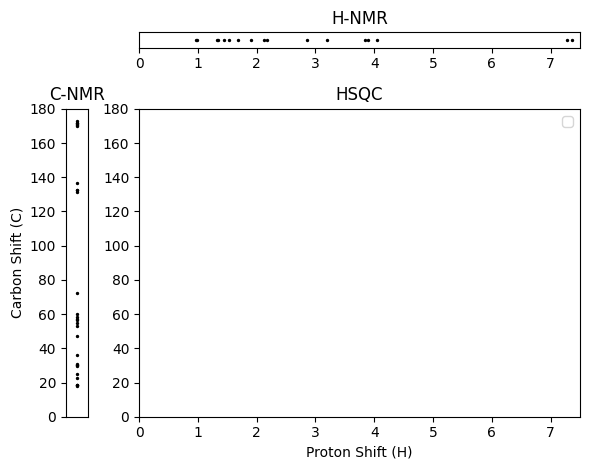

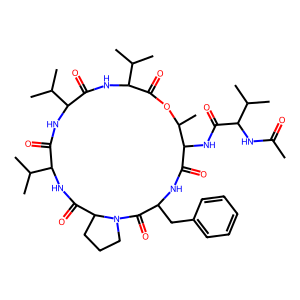

____________________________retival #15, cosine similarity: 0.7471680641174316_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin D


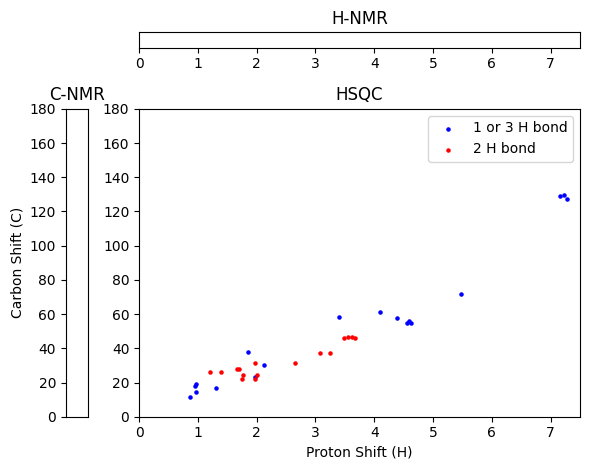

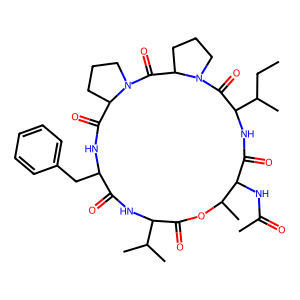

____________________________retival #16, cosine similarity: 0.7386698722839355_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide J


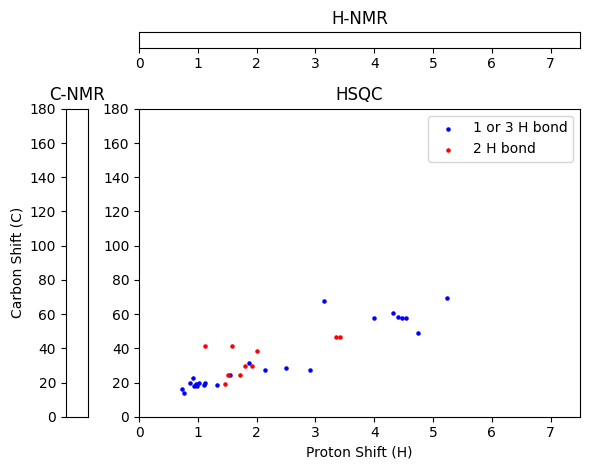

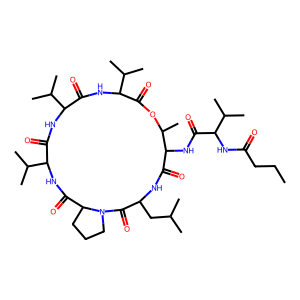

____________________________retival #17, cosine similarity: 0.7377128601074219_____________________________
SMILES: CCC(C)C1NC(=O)C(NC(C)=O)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccccc2)N(C)C(=O)C2CCCN2C(=O)C2CCCN2C1=O
Name aspergillicin C


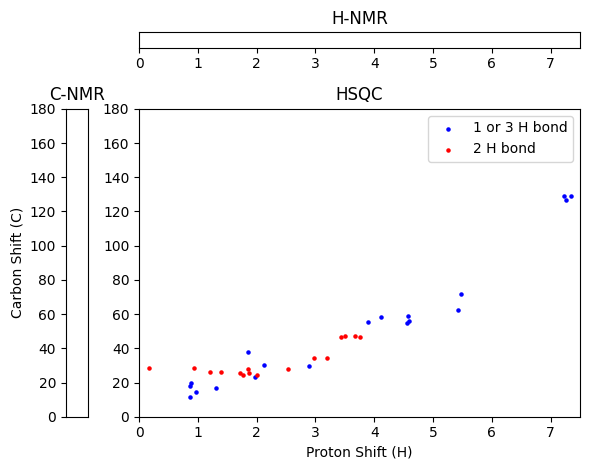

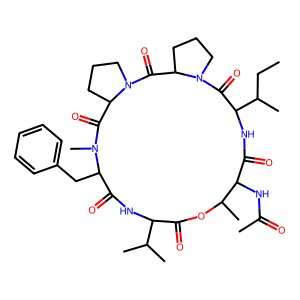

____________________________retival #18, cosine similarity: 0.72547447681427_____________________________
SMILES: CC(C)CC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide K


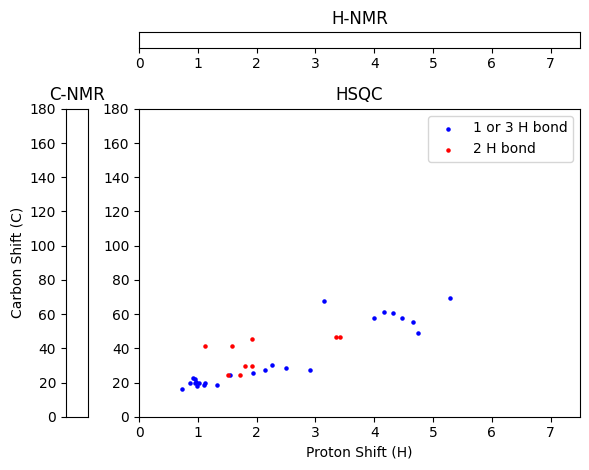

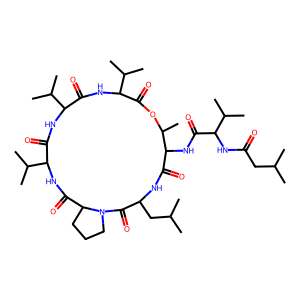

____________________________retival #19, cosine similarity: 0.7201542258262634_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)NC2CCC(O)N(C2=O)C(CC(C)C)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Tasipeptin A


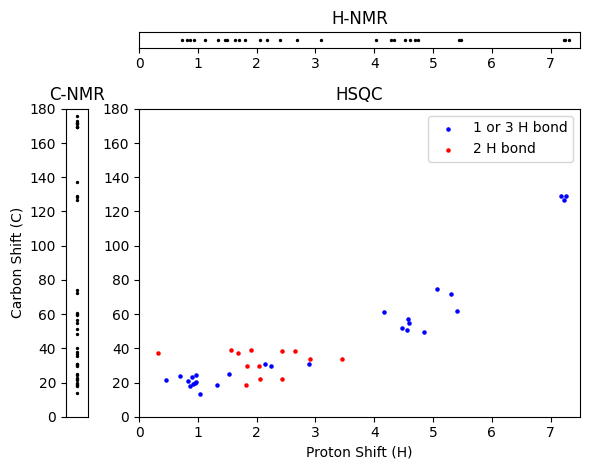

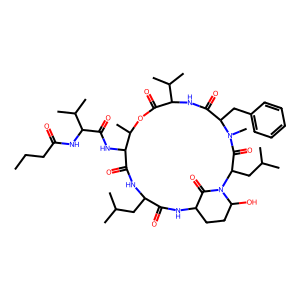

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #20, cosine similarity: 0.7189095616340637_____________________________
SMILES: CCC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin A


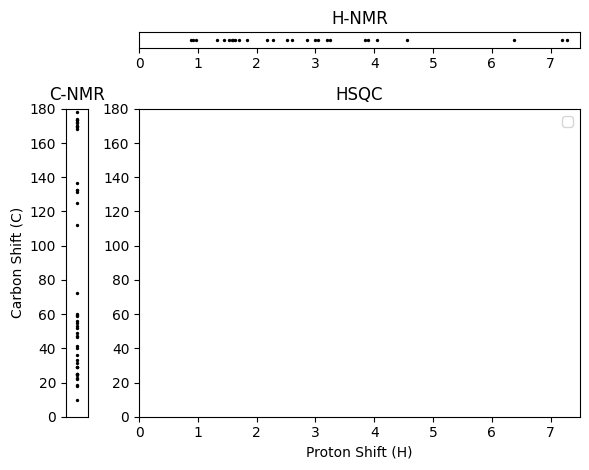

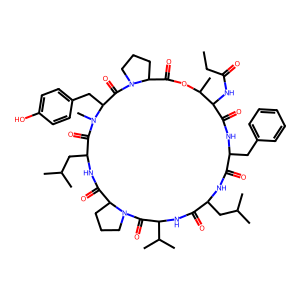

____________________________retival #21, cosine similarity: 0.7143604755401611_____________________________
SMILES: CCC(C)C1NC(=O)C2CCCN2C(=O)C(C)NC(=O)C2CCCN2C(=O)C(C(C)O)NC(=O)C(Cc2ccccc2)NC(=O)C(C)NC(=O)C(C)NC(=O)C(C(C)C)NC1=O
Name cycloleonuripeptide E


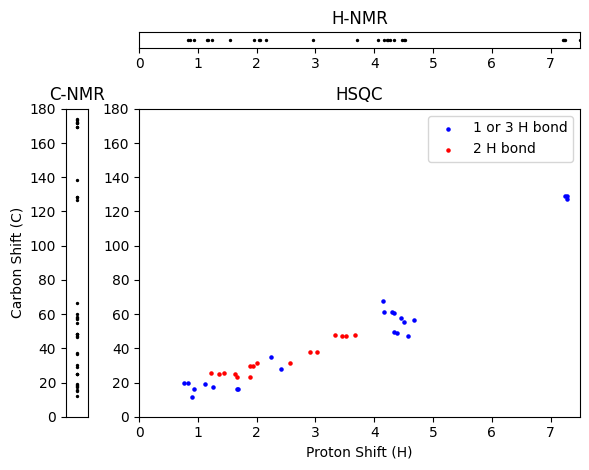

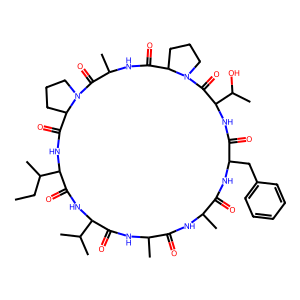

____________________________retival #22, cosine similarity: 0.7140575051307678_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)cc2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 9


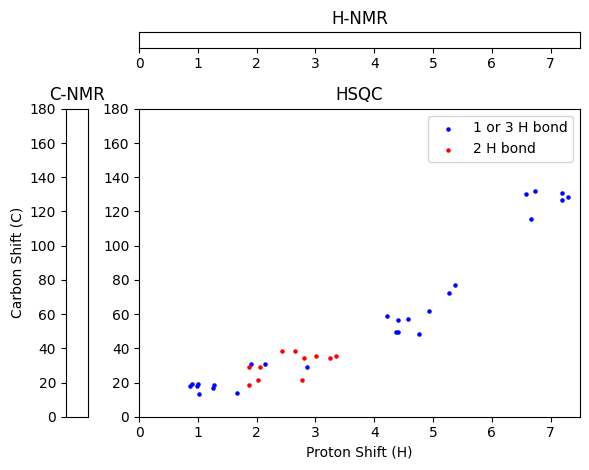

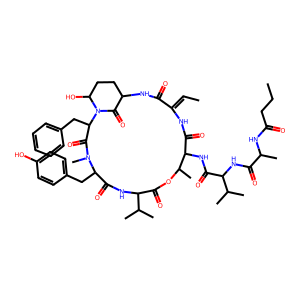

____________________________retival #23, cosine similarity: 0.7137889266014099_____________________________
SMILES: CC(C)CCCC(=O)NC(C(=O)NC1C(=O)NC(CC(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name Xentrivalpeptide M


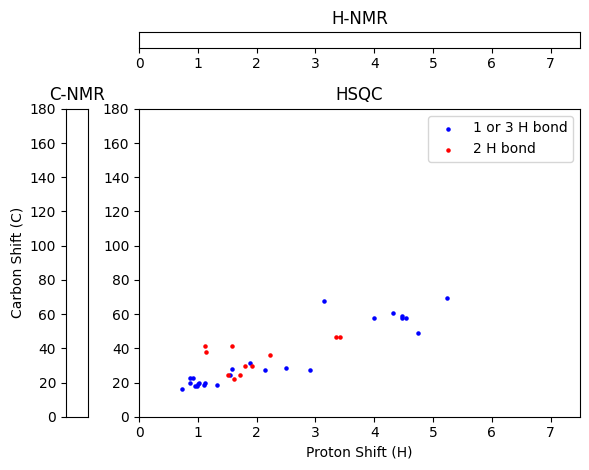

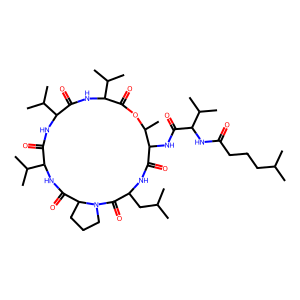

____________________________retival #24, cosine similarity: 0.7122557163238525_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide T


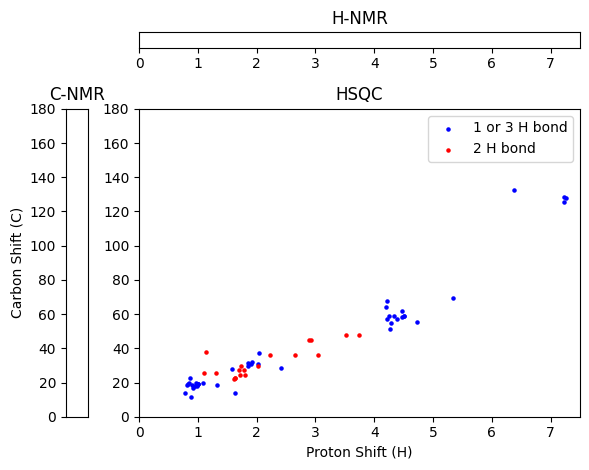

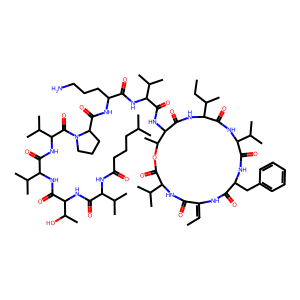

____________________________retival #25, cosine similarity: 0.7081567049026489_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide F


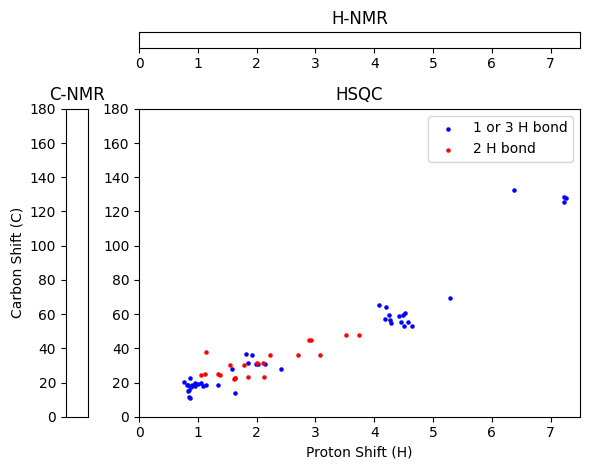

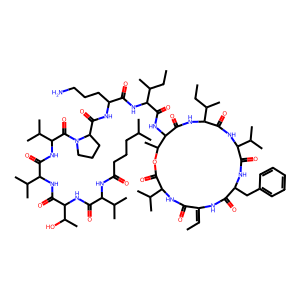

____________________________retival #26, cosine similarity: 0.7069028615951538_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name kahalalide U


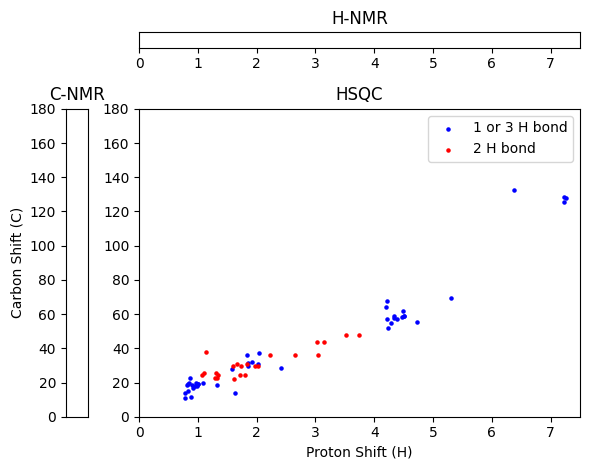

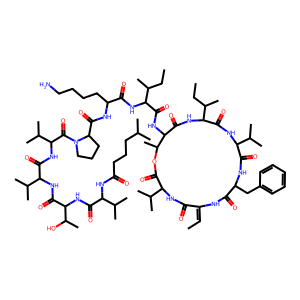

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #27, cosine similarity: 0.7052603960037231_____________________________
SMILES: CC(=O)NC1C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(Cc2ccc(O)cc2)C(=O)N(C)C(Cc2ccccc2)C(=O)NC(C)C(=O)OC1C
Name FJ120DPA


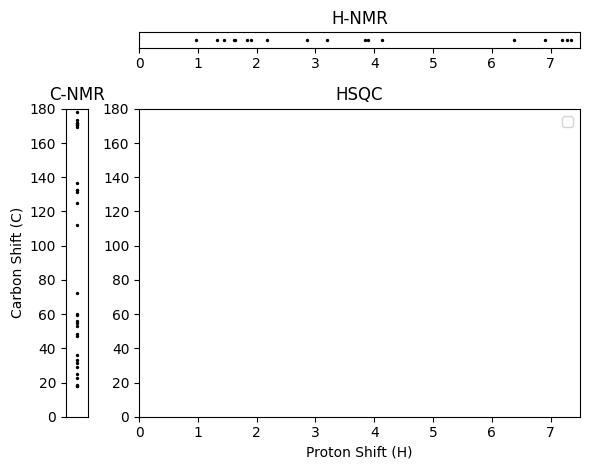

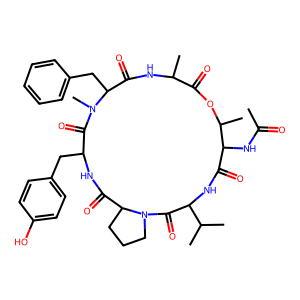

____________________________retival #28, cosine similarity: 0.7043770551681519_____________________________
SMILES: CCC(C)C1NC(=O)C(Cc2ccc(OC)cc2)NC(=O)C(NC(=O)C(NC=O)C(C)C)C(C)OC(=O)C(C(C)C)N(C)C(=O)C(CC(C)C)NC(=O)C2CCCNN2C1=O
Name marformycin A


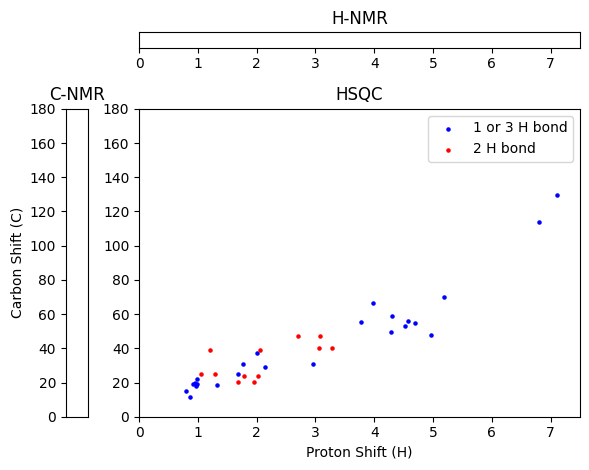

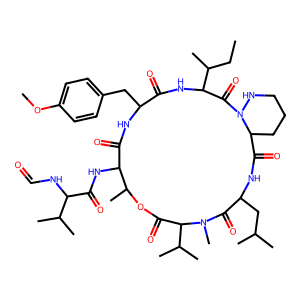

____________________________retival #29, cosine similarity: 0.703553318977356_____________________________
SMILES: CC=C1NC(=O)C(NC(=O)C(NC(=O)C(C)NC(=O)CCC)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(Cc2ccc(O)c(Br)c2)N(C)C(=O)C(Cc2ccccc2)N2C(=O)C(CCC2O)NC1=O
Name lyngbyastatin 10


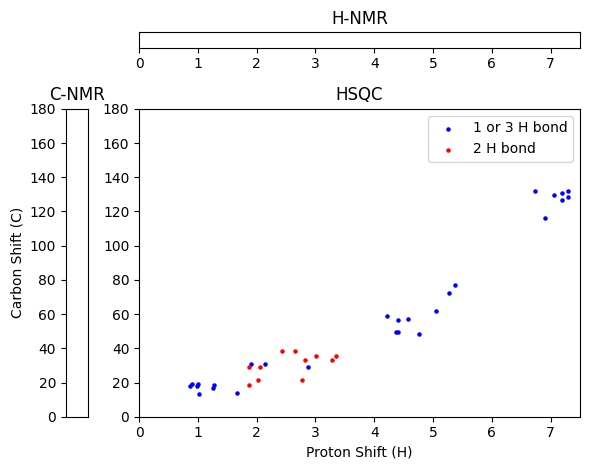

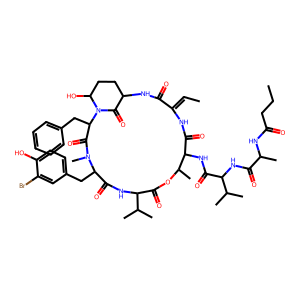

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________retival #30, cosine similarity: 0.7027554512023926_____________________________
SMILES: CC(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(=O)N2CCCC2C(=O)NC(CC(C)C)C(=O)N(C)C(Cc2ccc(O)cc2)C(=O)N2CCCC2C(=O)OC1C
Name Octaminomycin B


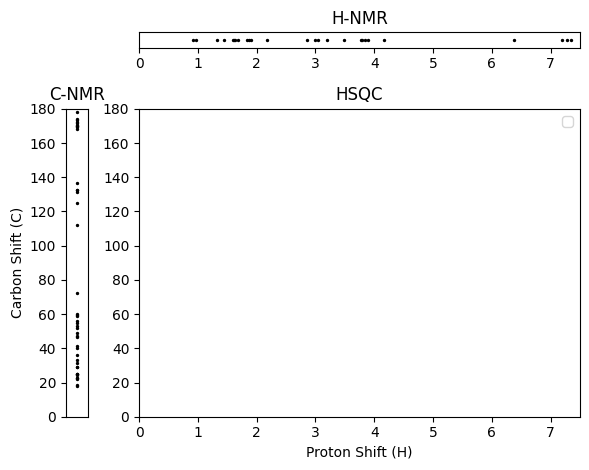

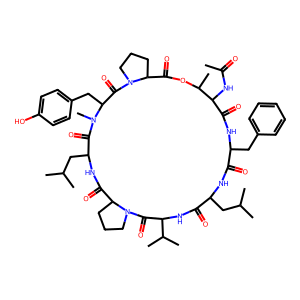

In [57]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir)
show_topK(inputs, k=30)